Copyright (c) 2024 Massachusetts Institute of Technology

SPDX-License-Identifier: MIT

# Observing a Satellite with a Custom Ground Sensor
In the previous example, we learned how to use `madlib` utilities to define and propagate a satellite. Now we will use `madlib` to define a custom ground-based optical sensor and use it to generate realistic astrometric observations.

## Defining Satellites
Let's quickly define 3 satellites:
1. A LEO object similar to the ISS
2. A GEO satellite at 0 degrees longitude
3. A GEO satellite at 270 degrees longitude

In [1]:
import madlib
import numpy as np

In [2]:
epoch_mjd = 60197.5

leo_alt_km = 430.0
leo_speed_kms = 27500.0 / 3600  # Converting from km/h to km/s
earth_radius_km = 6378.0

leo_pos_teted = np.array([leo_alt_km + earth_radius_km, 0, 0])
leo_vel_teted = leo_speed_kms * np.array([0, 2**-0.5, 2**-0.5])

leo_satellite = madlib.Satellite(epoch=epoch_mjd, pos=leo_pos_teted, vel=leo_vel_teted)

geo_satellite_0 = madlib.Satellite.from_GEO_longitude(lon=0, epoch=epoch_mjd)
geo_satellite_270 = madlib.Satellite.from_GEO_longitude(lon=270, epoch=epoch_mjd)

## Defining a Sensor
Now let's take a look at how `madlib` lets us define sensors. Currently, only optical sensors are supported, and these sensors can only measure satellite's angular positions, not their brightnesses or radial distances. `madlib` lets us create both ground-based sensors and sensors in Earth orbit, but we'll focus on the former for now.

Ground-based optical sensors are defined with the following parameters:
* **lat** - The geodetic latitude of the sensor, in degrees
* **lon** - The geodetic longitude of the sensor, in degrees (measured East of the Prime Meridian)
* **alt** - The altitude of the sensor, in km (measured above WGS-84 reference ellipsoid)
* **dra** - Metric accuracy of the sensor in the right ascension direction, measured in **arcseconds
* **ddec** - Metric accuracy of the sensor in the declination direction, measured in arcseconds
* **obs_per_collect** - Typical number of observations per collect (either fixed or randomly sampled from an interval)
* **obs_time_spacing** - The time in seconds between observations within a collect
* **collect_gap_mean** - Average time in seconds between collects
* **collect_gap_std** - Standard deviation of seconds between collects
* **obs_limits** - Various limits on what the sensor can observe, such as elevation limits
* **id** - A unique sensor ID string

Let's go step-by-step through these parameters to build an imaginary sensor near the [Haystack Observatory](https://en.wikipedia.org/wiki/Haystack_Observatory):

In [3]:
sensor_1_params = {}

# We'll start with the ID
sensor_1_params["id"] = "Needle"

# In degrees, the coordinates of Haystack are 42.6233 N, 71.4882 W
sensor_1_params["lat"] = 42.6233
sensor_1_params["lon"] = -71.4882

# The altitude of the observatory is 131 m
sensor_1_params["alt"] = 0.131

# Our imaginary telescope has mediocre imaginary funding, so our astrometric
# measurements are accurate to within ten arcseconds.
sensor_1_params["dra"] = 10.0
sensor_1_params["ddec"] = 10.0

# At each pointing of our scanning pattern, we'll take 3 observations, spaced 1 second apart
sensor_1_params["obs_per_collect"] = 3
sensor_1_params["obs_time_spacing"] = 1

# On average, we'll return to each pointing every 1 minute, give or take 5 seconds
sensor_1_params["collect_gap_mean"] = 60
sensor_1_params["collect_gap_std"] = 5

<div class="alert alert-block alert-info">
<b>Note:</b> Additional parameters allow you to simulate systematic errors in the sensor's reported position or have the sensor mistakenly observe an object near the target, but these are outside the scope of the current example.
</div>

### Observation Limits
In `madlib` you can pass in a dict of limiting behaviors that restrict the observations of your sensor. For instance, you may be modeling a sensor that cannot point below a certain elevation, can only observe a certain range of azimuth angles, or is very sensitive to the background brightness of early twilight.

Common supported observation limits are
* **dec** - Declination (in degrees)
* **az** - Azimuth (in degrees)
* **el** - Elevation angle (in degrees)
* **range_** - Distance to observed object (in km)
* **sun_el** - Elevation angle of the sun (in degrees)

Our sensor will have a minimum pointing elevation of 15 degrees, and it will only be effective during astronomical twilight (when the sun is 18 or more degrees below the horizon).

We define each limit as a tuple with `(minimum allowed value, maximum allowed value)`.

<div class="alert alert-block alert-info">
<b>Note:</b> Any observations that would fall outside of these limits will be ignored and won't be returned by our sensor's .observe function.
</div>

In [4]:
obs_limits = {"el": (15, 90), "sun_el": (-90, -18)}

sensor_1_params["obs_limits"] = obs_limits

Now we can finally define our `GroundOpticalSensor` object.

In [5]:
sensor_1 = madlib.GroundOpticalSensor(**sensor_1_params)

## Making Observations with a Sensor
We are ready to use our sensor to simulate observations of our satellites. Let's simulate 72 consecutive hours starting at the satellites' epoch.

Currently, `madlib` only supports observing a single satellite at a time, so let's start with our GEO object at 270 degrees longitude.

In [6]:
start_mjd = epoch_mjd
end_mjd = start_mjd + 3  # 3 days, or 72 hours, of observation time

In [7]:
geo_observations_270 = sensor_1.observe(
    target_satellite=geo_satellite_270, times=(start_mjd, end_mjd)
)
print(geo_observations_270)

ObservationCollection(pos_observed=array([Observation(mjd=60198.0288381947, ra=-92.0985296777439, dec=-6.491351755392359, az=206.33020117688616, el=37.37237039534833, range_=None, range_rate=None, lat=None, lon=None, sun_el=-18.001341475664166, sun_separation=None, sensor_id='Needle'),
       Observation(mjd=60198.02884976877, ra=-92.09310934444511, dec=-6.495381442626195, az=206.32706878736045, el=37.36896969043159, range_=None, range_rate=None, lat=None, lon=None, sun_el=-18.004127898483183, sun_separation=None, sensor_id='Needle'),
       Observation(mjd=60198.0295410948, ra=-91.83790200462018, dec=-6.499259734608577, az=206.31879623112025, el=37.36714952148726, range_=None, range_rate=None, lat=None, lon=None, sun_el=-18.170430318712338, sun_separation=None, sensor_id='Needle'),
       ...,
       Observation(mjd=60200.36442202112, ra=31.068356708980904, dec=-6.504800722471203, az=206.26007204578138, el=37.377489729597784, range_=None, range_rate=None, lat=None, lon=None, sun_el=-1

The output we received is an `ObservationCollection`, which is itself holds individual `Observation` objects.

An `ObservationCollection` holds two types of data in numpy arrays:
1. **pos_observed** - The observed position of the satellite at each valid observation time.
2. **pos_truth** - The *actual* position of the satellite at each valid observation time, ignoring sensor noise.
3. **pos_expected** - The position where the satellite was *expected* to be at each valid observation time, ignoring sensor noise and systematic errors. This is used for calculating residuals.

Note that `pos_expected` only follows the target satellite's original orbit, unaware of any maneuvers. It also does not apply any systematic errors in the target satellite's orbit or the sensor's position.

Each `Observation` in those arrays can have the following fields for an optical, ground-based sensor:
* **mjd** - Timestamp of observation in MJD format
* **ra** - Right Ascension of satellite, in degrees
* **dec** - Declination of satellite, in degrees
* **az** - Azimuth angle of satellite, in degrees
* **el** - Elevation angle of satellite, in degrees
* **sun_el** - Elevation angle of the sun at the observation time, in degrees

Let's examine these results in more detail. First, how many *valid* observations were collected for this object?

In [8]:
print(geo_observations_270.count_valid_observations())

4364


What were the measurements for the first observation? How do those compare to the ground truth and expected measurements? (Note that we have ground truth for the satellite's range and range rate, but our optical sensor cannot measure those values.)

In [9]:

print("Observation: ", geo_observations_270.pos_observed[0])
print("Ground Truth:", geo_observations_270.pos_truth[0])
print("Expected:    ", geo_observations_270.pos_expected[0])

Observation:  Observation(mjd=60198.0288381947, ra=-92.0985296777439, dec=-6.491351755392359, az=206.33020117688616, el=37.37237039534833, range_=None, range_rate=None, lat=None, lon=None, sun_el=-18.001341475664166, sun_separation=None, sensor_id='Needle')
Ground Truth: Observation(mjd=60198.0288381947, ra=-92.0948106922608, dec=-6.495278711207822, az=206.3241865981276, el=37.36987491594943, range_=None, range_rate=None, lat=None, lon=None, sun_el=-18.001341475664166, sun_separation=None, sensor_id='Needle')
Expected:     Observation(mjd=60198.0288381947, ra=-92.0948106922608, dec=-6.495278711207822, az=206.3241865981276, el=37.36987491594943, range_=None, range_rate=None, lat=None, lon=None, sun_el=-18.001341475664166, sun_separation=None, sensor_id='Needle')


### Observation Limits
What happens if we instead use the same telescope to look at the GEO object at 0 degrees longitude?

In [10]:
geo_observations_0 = sensor_1.observe(target_satellite=geo_satellite_0, times=(start_mjd, end_mjd))
print(geo_observations_0.count_valid_observations())

0


Zero observations were returned! This particular satellite is never within our sensor's field of view, so it is simply never observed. It's important to remember this edge case when working with sensor observations in `madlib`: your `ObservationCollection` objects will often be empty.

## Plotting Observations
Let's plot the measured RA and DEC of the GEO satellite at 270 degrees longitude.

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

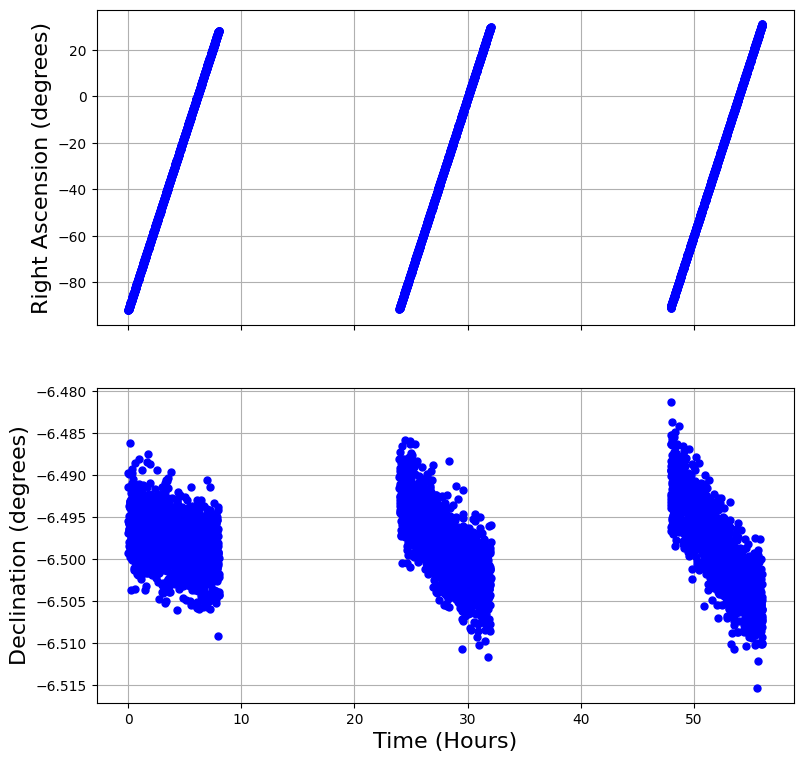

In [12]:
times = np.array([o.mjd for o in geo_observations_270.pos_observed])
times = 24 * (times - min(times))  # Convert the times from days to hours
ra = [o.ra for o in geo_observations_270.pos_observed]
dec = [o.dec for o in geo_observations_270.pos_observed]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9, 9))

_ = ax1.plot(times, ra, "ob", ms=5, lw=2)
ax1.set_ylabel("Right Ascension (degrees)", fontsize=16)
_ = ax2.plot(times, dec, "ob", ms=5, lw=2)
ax2.set_ylabel("Declination (degrees)", fontsize=16)
ax2.set_xlabel("Time (Hours)", fontsize=16)
ax1.grid()
ax2.grid()

Note how, by specifying a maximum sun elevation at which our sensor can operate, we've created gaps in the data during daytime hours. Also, the 10-arcsecond noise of our sensor is very evident in the plot of our declination measurements.

Let's compare this to a similar plot of observations of the LEO object:

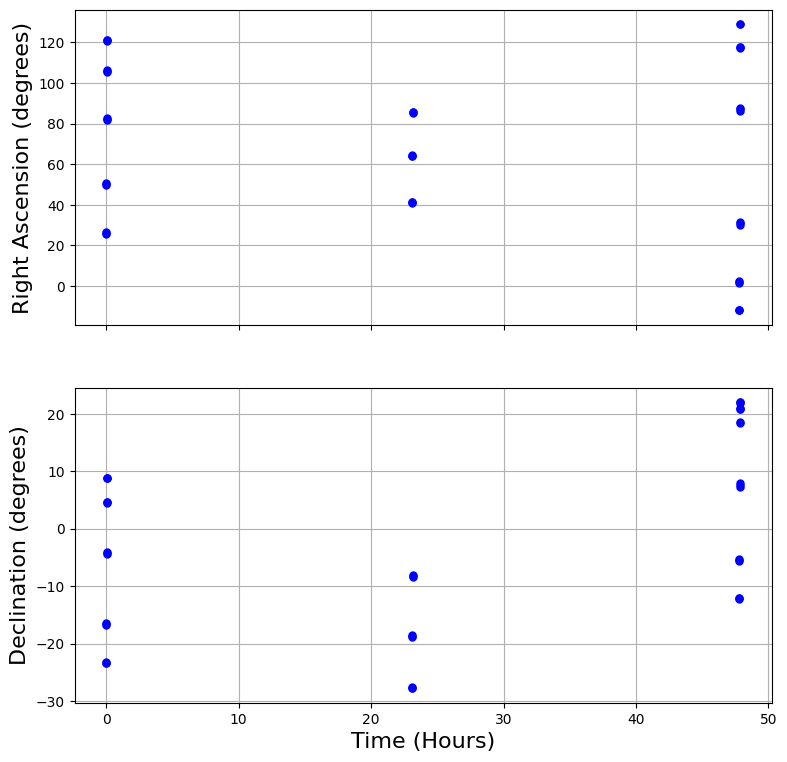

In [13]:
leo_observations = sensor_1.observe(target_satellite=leo_satellite, times=(start_mjd, end_mjd))

times = np.array([o.mjd for o in leo_observations.pos_observed])
times = 24 * (times - min(times))  # Convert the times from days to hours
ra = [o.ra for o in leo_observations.pos_observed]
dec = [o.dec for o in leo_observations.pos_observed]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9, 9))

_ = ax1.plot(times, ra, "ob", ms=5, lw=2)
ax1.set_ylabel("Right Ascension (degrees)", fontsize=16)
_ = ax2.plot(times, dec, "ob", ms=5, lw=2)
ax2.set_ylabel("Declination (degrees)", fontsize=16)
ax2.set_xlabel("Time (Hours)", fontsize=16)
ax1.grid()
ax2.grid()

This fast-moving object is, of course, much more difficult to observe than the stationary GEO satellite, and we only obtain a handful of observations before it leaves the field of view. Zooming in, you can see how observations are clustered around collection times.

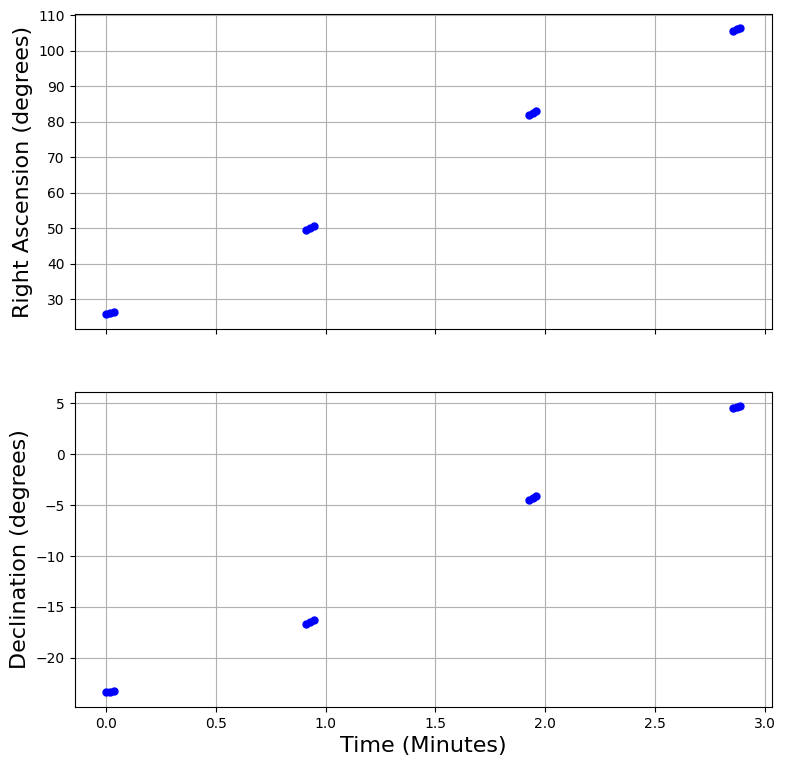

In [14]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9, 9))

_ = ax1.plot(60 * times[:12], ra[:12], "ob", ms=5, lw=2)
ax1.set_ylabel("Right Ascension (degrees)", fontsize=16)
_ = ax2.plot(60 * times[:12], dec[:12], "ob", ms=5, lw=2)
ax2.set_ylabel("Declination (degrees)", fontsize=16)
ax2.set_xlabel("Time (Minutes)", fontsize=16)
ax1.grid()
ax2.grid()

The sensor parameter "obs_per_collect" was set to 3, and "obs_time_spacing" was set to 1, so each of these collections contains 3 observations spaced 1 second apart.

The parameters "collect_gap_mean" and "collect_gap_std" were set to 60 and 5, respectively, so there is on average a 60-second gap in between collections, with 5 seconds of normally distributed uncertainty.

Using these four parameters allows you to roughly approximate the behaviors of sensors that periodically sweep across different pointings in the sky.